### Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from collections import Counter

### Verifying raw data path
If assertion fails, download the movielens-100k ratings data from [konect](http://konect.cc/networks/movielens-100k_rating/) and put the files in data/raw.

In [2]:
raw_data_path ="data/raw/rel.rating.csv"
assert os.path.exists(raw_data_path)
figure_save_path = "data/figures"

### Create a graph

In [3]:
G = nx.Graph()

with open(raw_data_path, 'r') as f:
    movie_ids = set()
    user_ids = set()
    edges = []
    for line in f.readlines():
        userid, movieid, rating, timestamp = tuple(map(int, line.strip().split(' ')))
        movie_ids.add(movieid)
        userid += 10000
        user_ids.add(userid)
        edges.append((userid, movieid, rating))  # Discarding the timestamp attribute of edges

G.add_nodes_from(user_ids, bipartite=0)
G.add_nodes_from(movie_ids, bipartite=1)
G.add_weighted_edges_from(edges)

True

### Weight (Rating) Distribution

(3.52986, 1.1256679707622492)

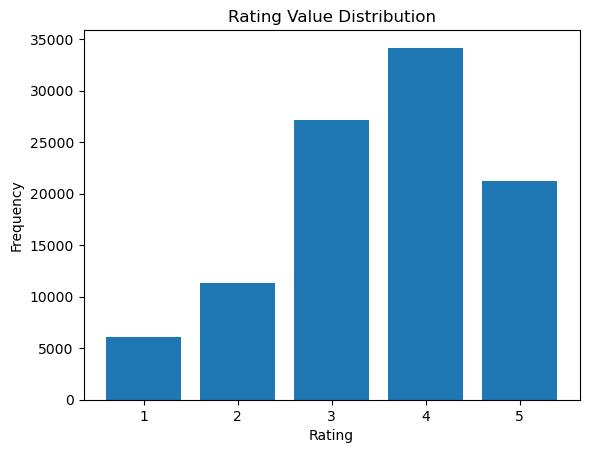

In [18]:
weights = list(edge[2]['weight'] for edge in G.edges(data=True))
unique, count = np.unique(weights, return_counts=True)
plt.bar(unique, count)
plt.title("Rating Value Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency");
np.mean(weights), np.std(weights)

### Degree Distribution

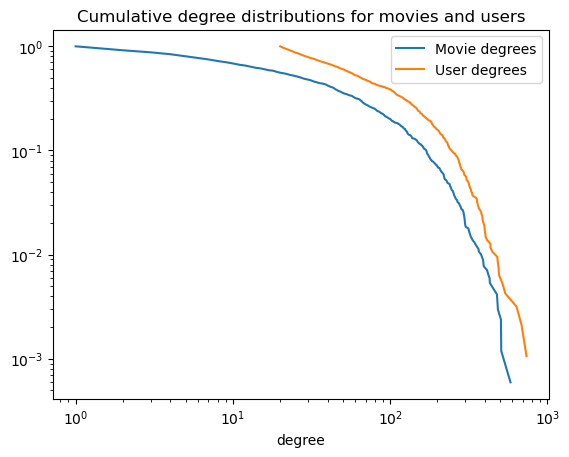

In [12]:
def plot_ccdf(degree_dictionary):  # takes dict(G.degree)
   dd = Counter(degree_dictionary.values())
   dd = pd.DataFrame(list(dd.items()), columns = ("degree", "count")).sort_values(by = "degree")
   ccdf = dd.sort_values(by = "degree", ascending = False)
   ccdf["cumsum"] = ccdf["count"].cumsum()
   ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
   ccdf = ccdf[["degree", "ccdf"]].sort_values(by = "degree")
   return ccdf

movie_degrees = {k:v for k,v in dict(G.degree()).items() if k < 10000}
user_degrees = {k:v for k,v in dict(G.degree()).items() if k >= 10000}

movie_ccdf = plot_ccdf(movie_degrees)
user_ccdf = plot_ccdf(user_degrees)

ax = plt.gca()
ax.set_title("Cumulative degree distributions for movies and users")
movie_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Movie degrees', ax=ax)
user_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='User degrees', ax=ax);

The distributions are not power law; they are shifted and there is exponential cutoff. There is an obvious minumum of movies rated by any user (20), but some movies are rated by very few people (min is 1).

In [5]:
min(user_degrees.values()), min(movie_degrees.values())

(20, 1)

Add for next time:
add degree distribution plots
summary statistics 
check for power low